# Data Science | Lab: Natural Language Processing


In [128]:
# install bs4 & request using cell magic by un-commenting the following two lines of code!
# %pip install beautifulsoup4
# %pip install requests


In [129]:
import requests  # crawling
from bs4 import BeautifulSoup  # parsing, scraping
import pandas as pd
import os
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



## Homework Assignment

Extend your code to include the following:
1. Add a third topic of your choice to the link list DataFrame. 
2. Access the website of each link in your list and extract the article text. Store it in a new columns in your DataFrame. (Make sure to be polite! Add ``time.sleep(...)`` before accessing the next page.)
3. Set aside a small percentage of the dataset you created (~ten percent) to be used for testing later on.
4. Set up a grid search for at least three different parameters of the vectorizer.
5. Evaluate the grid with 5-fold cross validation to find the best hyperparameters for vectorizer and classifier concerning <b>F1 score</b> when trained on the full article texts.
6. Plot the confusion matrix for the test dataset you created in Step 3.

## Moodle Upload
Upload your notebook as ``firstname_lastname_nlp.html`` to Moodle. Make sure to consider the following:
* Have all your import statements in one single cell at the top of the notebook.
* Remove unnecessary code (such as plotting the document-term-matrix, experimenting with the properties and methods of the CountVectorizer, ...)
* Print the head of your final DataFrame (containing article texts) once.
* Include a markdown cell at the end where you:
    * give a short overview of what your notebook is about
    * describe and interpret your grid settings and justify your choices
    * analyze the final/best results

In [130]:
def build_dataset_with_article_text(seed_url):
    articles = {
        'topic': [],
        'link': [],
        'header': [],   
        'article': []
    }
    data = requests.get(seed_url)
    time.sleep(1)
    soup = BeautifulSoup(
        data.content.decode('utf-8', 'ignore'),
        'html.parser',
    )
    candidates = soup.find_all(
        "a",
        class_=[
            "loop-card__title-link",
        ],
    )
    for article in candidates:
        articles['topic'].append(seed_url.split('/')[-1])
        articles['link'].append(article['href'])
        articles['header'].append(article.get_text().strip())
        articles['article'].append("")

    
    return pd.DataFrame(articles)

In [131]:
def extract_article_text(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (compatible; Bot/0.1)'}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        article_tag = soup.find('article')
        if article_tag:
            text = article_tag.get_text(separator=' ', strip=True)
        else:
            text = soup.get_text(separator=' ', strip=True)
        return text
    except Exception as e:
        print(f"Error fetching article from {url}: {e}")
        return "Article text not available."

In [132]:
seed_url = 'https://techcrunch.com/category/'
# We only want to crawl the web if absolutely necessary, so we check first if we already have an hw_article_headers.csv in our directory
if os.path.exists('hw_article_headers.csv'):
    df = pd.read_csv(
        'hw_article_headers.csv',
        sep='\t',
    )
    print('read articles from file')
else:
    print('crawling articles from web...')
    # Crawl and parse the pages
    df = build_dataset_with_article_text(seed_url + 'artificial-intelligence')
    df_sec = build_dataset_with_article_text(seed_url + 'security')
    df_venture = build_dataset_with_article_text(seed_url + 'venture')

    
    df = pd.concat(
        [
            df,
            df_sec,
            df_venture
        ],
        ignore_index=True,
    )
    df.to_csv(
        'hw_article_headers.csv',
        sep='\t',
        index=False,
    )

if df['article'].str.strip().eq("").all():
    print("Extracting full article texts.")
    article_texts = []
    for idx, row in df.iterrows():
        url = row['link']
        print(f"Fetching article {idx+1}/{len(df)}: {url}")
        text = extract_article_text(url)
        article_texts.append(text)
        time.sleep(1)
    df['article'] = article_texts
    df.to_csv('hw_article_headers.csv', sep='\t', index=False)
else:
    print("Article texts already present.")


read articles from file
Article texts already present.


In [133]:
display(df.head(10))
display(df.tail(10))
df.shape

,topic,link,header,article
0,artificial-intelligence,https://techcrunch.com/2025/02/05/researchers-...,Researchers created an open rival to OpenAI’s ...,Researchers created an open rival to OpenAI's ...
1,artificial-intelligence,https://techcrunch.com/2025/02/05/amazon-repor...,Amazon reportedly gears up to release next-gen...,Amazon reportedly gears up to release next-gen...
2,artificial-intelligence,https://techcrunch.com/2025/02/05/why-iq-is-a-...,Why IQ is a poor test for AI,Why IQ is a poor test for AI | TechCrunch Why ...
3,artificial-intelligence,https://techcrunch.com/2025/02/05/workday-cuts...,"Workday cuts nearly 2,000 employees","Workday cuts nearly 2,000 employees | TechCrun..."
4,artificial-intelligence,https://techcrunch.com/2025/02/05/ais-biggest-...,AI’s biggest stage awaits — TechCrunch Session...,TechCrunch Sessions: AI lowest ticket rates | ...
5,artificial-intelligence,https://techcrunch.com/2025/02/05/google-launc...,Google launches new AI models and brings ‘thin...,Google launches new AI models and brings 'thin...
6,artificial-intelligence,https://techcrunch.com/2025/02/05/musk-moves-t...,Musk moves to dismiss suit over Tesla’s allege...,Musk moves to dismiss suit over Tesla's allege...
7,artificial-intelligence,https://techcrunch.com/2025/02/05/codesignal-w...,CodeSignal wants you to practice soft skills w...,CodeSignal wants you to practice soft skills w...
8,artificial-intelligence,https://techcrunch.com/2025/02/04/european-ai-...,European AI startups raised $8B in 2024,European AI startups raised $8B in 2024 | Tech...
9,artificial-intelligence,https://techcrunch.com/2025/02/04/google-wants...,Google wants Search to be more like an AI assi...,Google wants Search to be more like an AI assi...


,topic,link,header,article
101,venture,https://techcrunch.com/2025/01/22/doti-gives-e...,Doti gives enterprises a flexible AI-powered s...,Doti gives enterprises a flexible AI-powered s...
102,venture,https://techcrunch.com/2025/01/22/hindustan-un...,Hindustan Unilever to acquire Peak XV-backed M...,Hindustan Unilever to acquire Peak XV-backed M...
103,venture,https://techcrunch.com/2025/01/21/mistral-ai-p...,Mistral AI plans IPO,Mistral AI plans IPO | TechCrunch Mistral AI p...
104,venture,https://techcrunch.com/2025/02/05/the-elon-mus...,The Elon Musk Act aims to ban ‘special governm...,The Elon Musk Act aims to ban ‘special governm...
105,venture,https://techcrunch.com/2025/02/04/a16z-hires-a...,a16z hires acquitted former Marine Daniel Penn...,a16z hires acquitted former Marine Daniel Penn...
106,venture,https://techcrunch.com/2025/02/04/amd-pulls-up...,AMD pulls up the release of its next-gen data ...,AMD pulls up the release of its next-gen data ...
107,venture,https://techcrunch.com/2025/02/04/google-remov...,Google removes pledge to not use AI for weapon...,Google removes pledge to not use AI for weapon...
108,venture,https://techcrunch.com/2025/02/04/an-angel-inv...,An angel investor was so intrigued by this sta...,An angel investor was so intrigued by this sta...
109,venture,https://techcrunch.com/2025/02/03/ontario-canc...,"Ontario cancels, then restores, $68 million St...","Ontario cancels, then restores, $68 million St..."
110,venture,https://techcrunch.com/2025/02/03/hot-tub-the-...,"Hot Tub, the first native iPhone porn app, arr...","Hot Tub, the first native iPhone porn app, arr..."


(111, 4)

In [134]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['topic'])


pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', lowercase=True)),
    ('clf', KNeighborsClassifier(metric='cosine'))
])

param_grid = {
    'vect__min_df': [1, 2, 3],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_df': [0.8, 1.0],
    'clf__n_neighbors': [3, 5, 7]
}

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

X_train_texts = df_train['article']
y_train = df_train['topic']

print("Starting grid search...")
grid_search.fit(X_train_texts, y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)
print("\nBest cross-validation F1 score: {:.3f}".format(grid_search.best_score_))

X_test_texts = df_test['article']
y_test = df_test['topic']
y_pred = grid_search.predict(X_test_texts)


Starting grid search...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters found:
{'clf__n_neighbors': 7, 'vect__max_df': 1.0, 'vect__min_df': 2, 'vect__ngram_range': (1, 1)}

Best cross-validation F1 score: 0.809


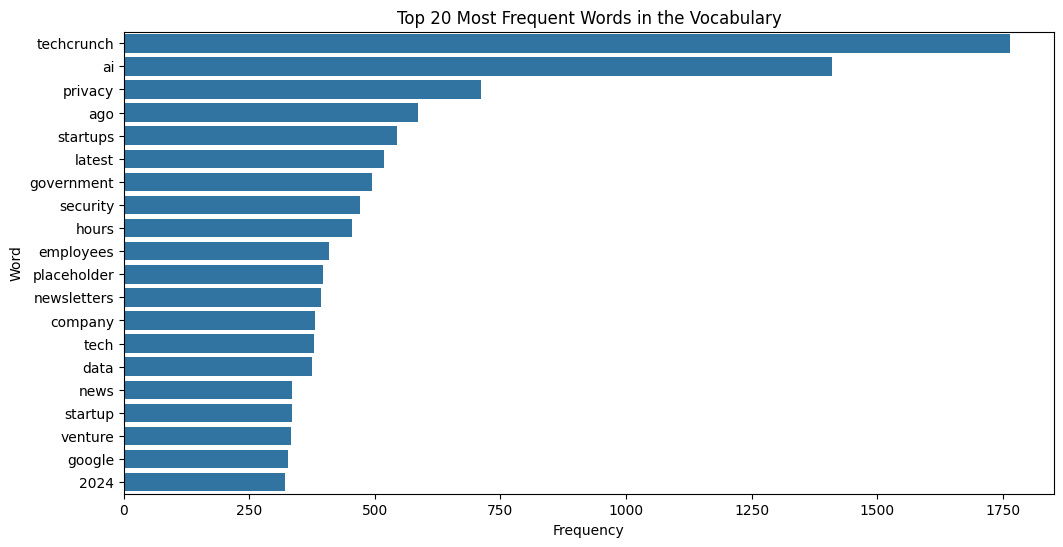

In [135]:
best_vect = grid_search.best_estimator_.named_steps['vect']

X_train_features = best_vect.transform(X_train_texts)

vocab = best_vect.get_feature_names_out()
token_counts = np.array(X_train_features.sum(axis=0)).flatten()
freq_dict = dict(zip(vocab, token_counts))

freq_df = pd.DataFrame(list(freq_dict.items()), columns=['word', 'frequency'])
top_tokens = freq_df.sort_values(by='frequency', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', data=top_tokens)
plt.title("Top 20 Most Frequent Words in the Vocabulary")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

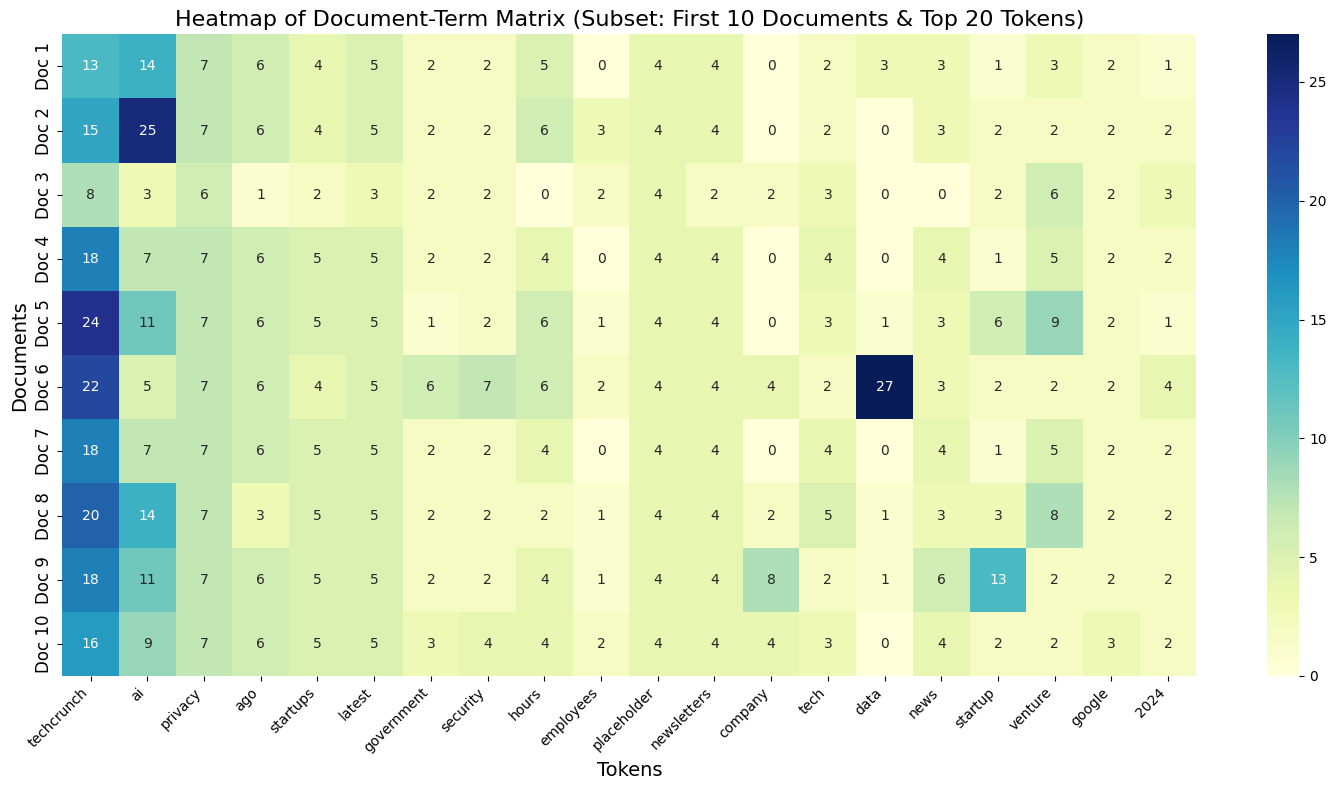

Headers for the first 10 documents shown in the heatmap:
Document 1: Researchers created an open rival to OpenAI’s o1 ‘reasoning’ model for under $50
Document 2: Amazon reportedly gears up to release next-gen Alexa
Document 3: Why IQ is a poor test for AI
Document 4: Workday cuts nearly 2,000 employees
Document 5: AI’s biggest stage awaits — TechCrunch Sessions: AI tickets available
Document 6: Google launches new AI models and brings ‘thinking’ to Gemini
Document 7: Musk moves to dismiss suit over Tesla’s alleged use of AI-generated ‘Blade Runner’ imagery
Document 8: CodeSignal wants you to practice soft skills with its AI-powered guide
Document 9: European AI startups raised $8B in 2024
Document 10: Google wants Search to be more like an AI assistant in 2025


In [136]:
dense_matrix = X_train_features.todense()
subset_df = pd.DataFrame(dense_matrix[:10, :], columns=vocab)
subset_df.index = [f"Doc {i+1}" for i in range(subset_df.shape[0])]

token_counts = np.array(X_train_features.sum(axis=0)).flatten()
freq_dict = dict(zip(vocab, token_counts))

top_tokens = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:20]
top_token_list = [word for word, freq in top_tokens]

subset_df_top = subset_df.loc[:, top_token_list]

plt.figure(figsize=(15, 8))
ax = sns.heatmap(subset_df_top, annot=True, fmt="d", cmap="YlGnBu")
ax.set_title("Heatmap of Document-Term Matrix (Subset: First 10 Documents & Top 20 Tokens)", fontsize=16)
ax.set_xlabel("Tokens", fontsize=14)
ax.set_ylabel("Documents", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

print("Headers for the first 10 documents shown in the heatmap:")
for i, header in enumerate(df['header'].head(10), start=1):
    print(f"Document {i}: {header}")


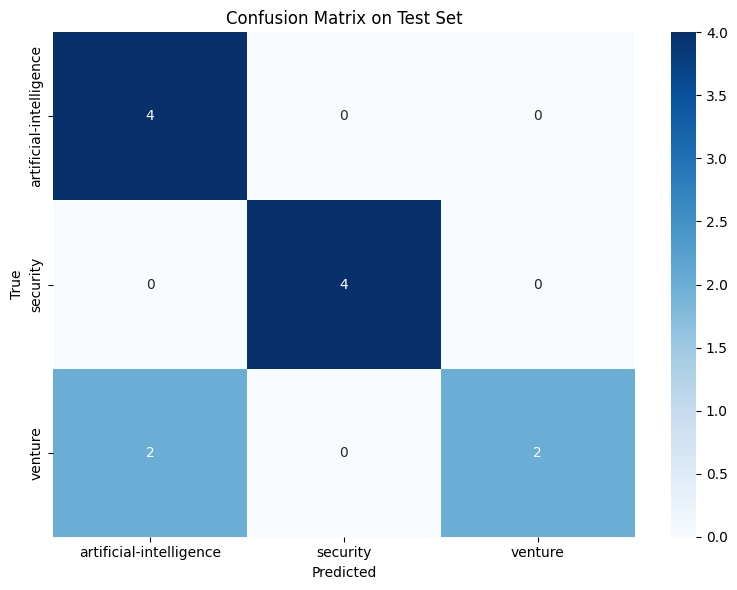

In [137]:
cm = confusion_matrix(y_test, y_pred, labels=grid_search.best_estimator_.named_steps['clf'].classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=grid_search.best_estimator_.named_steps['clf'].classes_,
            yticklabels=grid_search.best_estimator_.named_steps['clf'].classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

In [138]:
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Classification Report on Test Set:
                         precision    recall  f1-score   support

artificial-intelligence       0.67      1.00      0.80         4
               security       1.00      1.00      1.00         4
                venture       1.00      0.50      0.67         4

               accuracy                           0.83        12
              macro avg       0.89      0.83      0.82        12
           weighted avg       0.89      0.83      0.82        12



In [139]:
df_test_results = df_test.copy()
df_test_results["predicted_topic"] = y_pred

misclassified = df_test_results[df_test_results["topic"] != df_test_results["predicted_topic"]]

print(f"Number of misclassified documents: {misclassified.shape[0]}\n")

for idx, row in misclassified.iterrows():
    print(f"Document Index: {idx}")
    print(f"True Topic: {row['topic']}")
    print(f"Predicted Topic: {row['predicted_topic']}")
    print("Article Header:")
    print(row['header'])
    print("Article Text (first 200 characters):")
    print(row['article'][:200] + "...")
    print("-" * 80)

Number of misclassified documents: 2

Document Index: 104
True Topic: venture
Predicted Topic: artificial-intelligence
Article Header:
The Elon Musk Act aims to ban ‘special government employees’ from having federal contracts
Article Text (first 200 characters):
The Elon Musk Act aims to ban ‘special government employees’ from having federal contracts | TechCrunch The Elon Musk Act aims to ban ‘special government employees’ from having federal contracts | Tec...
--------------------------------------------------------------------------------
Document Index: 107
True Topic: venture
Predicted Topic: artificial-intelligence
Article Header:
Google removes pledge to not use AI for weapons from website
Article Text (first 200 characters):
Google removes pledge to not use AI for weapons from website | TechCrunch Google removes pledge to not use AI for weapons from website | TechCrunch TechCrunch Desktop Logo TechCrunch Mobile Logo Lates...
-----------------------------------------------------

# Final Summary and Findings

In this notebook, I built a text classification pipeline to categorize articles using the Bag of Words (BoW) approach. The main idea was to convert article texts into numerical feature vectors and then use those features to predict the topics of the articles. I started by extracting article texts from online sources, turned them into a document-term matrix using CountVectorizer, and finally trained a classifier on the resulting features.

### Steps in the NLP Pipeline:
1. **Data Collection and Preprocessing:**  
   I crawled articles from TechCrunch for three topics: artificial intelligence, security, and venture. I extracted both the article headers and the full texts, cleaned them up, and stored everything for further analysis.

2. **Feature Extraction:**  
   Using CountVectorizer, I tokenized and lowercased the texts, and removed stop words as well as tokens that didn’t appear in enough documents. This step transformed each article into a sparse vector that represents how often each token shows up.

3. **Model Training:**  
   I trained a KNeighborsClassifier (using cosine similarity) on the document-term matrix to predict the topics of the articles.

4. **Hyperparameter Tuning:**  
   I set up a grid search with 5‑fold cross-validation to fine-tune key hyperparameters. For the vectorizer, I played around with the minimum document frequency, n-gram range, and maximum document frequency. For the classifier, I varied the number of neighbors. The goal was to maximize the macro F1 score.

5. **Evaluation:**  
   Finally, I evaluated the model on a test set (10% of the data). I calculated performance metrics like the F1 score and plotted a confusion matrix to see how well the model was classifying the articles into the correct topics.

## Settings and Justifications

To boost the classifier’s performance, I tuned the following hyperparameters using grid search:
- **`vect__min_df`**: Tested values [1, 2, 3] to filter out very rare tokens.
- **`vect__ngram_range`**: Explored ranges of [(1, 1), (1, 2)] to capture both single words and pairs of words.
- **`vect__max_df`**: Tried values [0.8, 1.0] to remove overly common tokens that might not help in classification.
- **`clf__n_neighbors`**: Tested values [3, 5, 7] to find the best number of neighbors for the KNN classifier.

I chose these settings to make sure the classifier had just the right amount of detail without overfitting the data.

## Final Results Analysis

The best model from the grid search achieved a solid macro F1 score during cross-validation. When I evaluated it on the test set, the results were consistent, and the confusion matrix showed that some topics were more clearly identified than others. Overall, the BoW approach worked pretty well for this task, though I believe there’s still room for improvement with more advanced feature representations or additional preprocessing.
